In [1]:
# -*- coding: utf-8 -*-

import requests, json, re, os, random, time, math
from PIL import Image
from io import BytesIO

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626 # π
a = 6378245.0 # 长半轴
ee = 0.00669342162296594323 # 扁率
#百度墨卡托投影纠正矩阵
LLBAND =[75, 60, 45, 30, 15, 0]
LL2MC = [[-0.0015702102444, 111320.7020616939, 1704480524535203, -10338987376042340, 26112667856603880, -35149669176653700, 26595700718403920, -10725012454188240, 1800819912950474, 82.5],
         [0.0008277824516172526, 111320.7020463578, 647795574.6671607, -4082003173.641316, 10774905663.51142, -15171875531.51559, 12053065338.62167, -5124939663.577472, 913311935.9512032, 67.5],
         [0.00337398766765, 111320.7020202162, 4481351.045890365, -23393751.19931662, 79682215.47186455, -115964993.2797253, 97236711.15602145, -43661946.33752821, 8477230.501135234, 52.5],
         [0.00220636496208, 111320.7020209128, 51751.86112841131, 3796837.749470245, 992013.7397791013, -1221952.21711287, 1340652.697009075, -620943.6990984312, 144416.9293806241, 37.5],
         [-0.0003441963504368392, 111320.7020576856, 278.2353980772752, 2485758.690035394, 6070.750963243378, 54821.18345352118, 9540.606633304236, -2710.55326746645, 1405.483844121726, 22.5],
         [-0.0003218135878613132, 111320.7020701615, 0.00369383431289, 823725.6402795718, 0.46104986909093, 2351.343141331292, 1.58060784298199, 8.77738589078284, 0.37238884252424, 7.45]]
# 百度墨卡托转回到百度经纬度纠正矩阵
MCBAND = [12890594.86, 8362377.87, 5591021, 3481989.83, 1678043.12, 0]
MC2LL = [[1.410526172116255e-8, 0.00000898305509648872, -1.9939833816331, 200.9824383106796, -187.2403703815547, 91.6087516669843, -23.38765649603339, 2.57121317296198, -0.03801003308653, 17337981.2],
      [-7.435856389565537e-9, 0.000008983055097726239, -0.78625201886289, 96.32687599759846, -1.85204757529826, -59.36935905485877, 47.40033549296737, -16.50741931063887, 2.28786674699375, 10260144.86],
      [-3.030883460898826e-8, 0.00000898305509983578, 0.30071316287616, 59.74293618442277, 7.357984074871, -25.38371002664745, 13.45380521110908, -3.29883767235584, 0.32710905363475, 6856817.37],
      [-1.981981304930552e-8, 0.000008983055099779535, 0.03278182852591, 40.31678527705744, 0.65659298677277, -4.44255534477492, 0.85341911805263, 0.12923347998204, -0.04625736007561, 4482777.06],
      [3.09191371068437e-9, 0.000008983055096812155, 0.00006995724062, 23.10934304144901, -0.00023663490511, -0.6321817810242, -0.00663494467273, 0.03430082397953, -0.00466043876332, 2555164.4],
      [2.890871144776878e-9, 0.000008983055095805407, -3.068298e-8, 7.47137025468032, -0.00000353937994, -0.02145144861037, -0.00001234426596, 0.00010322952773, -0.00000323890364, 826088.5]]
def gcj02tobd09(lng, lat):
    """
    火星坐标系(GCJ02)转百度坐标系(BD09)
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
 
def bd09togcj02(bd_lon, bd_lat):
    """
    百度坐标系(BD09)转火星坐标系(GCJ02)
    :param bd_lat:百度坐标纬度
    :param bd_lon:百度坐标经度
    :return:转换后的坐标列表形式
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
 
def wgs84togcj02(lng, lat):
    """
    WGS84转GCJ02(火星坐标系)
    :param lng:WGS84坐标系的经度
    :param lat:WGS84坐标系的纬度
    :return:
    """
    if out_of_china(lng, lat): # 判断是否在国内
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
 
def wgstobd09(lon, lat):
    tmplon, tmplat = wgs84togcj02(lon, lat)
    return gcj02tobd09(tmplon, tmplat)

def wgstobdmc(lon, lat):
    tmplon, tmplat = wgstobd09(lon, lat)
    return bd09tomercator(tmplon, tmplat)
 
def gcj02towgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    if out_of_china(lng, lat):
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
 
def transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + 0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
    math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
    math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
 
def transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + 0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
 
def out_of_china(lng, lat):
    """
    判断是否在国内，不在国内不做偏移
    :param lng:
    :param lat:
    :return:
    """
    if lng < 72.004 or lng > 137.8347:
        return True
    if lat < 0.8293 or lat > 55.8271:
        return True
    return False
 
def wgs84tomercator(lng,lat):
    """
    wgs84投影到墨卡托
    :param lng:
    :param lat:
    :return:
    """
    x = lng * 20037508.34 / 180
    y = math.log(math.tan((90 + lat) * math.pi / 360)) / (math.pi / 180) * 20037508.34 / 180
    return x,y
def mercatortowgs84(x,y):
    """
    墨卡托投影坐标转回wgs84
    :param x:
    :param y:
    :return:
    """
    lng = x / 20037508.34 * 180
    lat = 180 / math.pi * (2 * math.atan(math.exp(y / 20037508.34 * 180 * math.pi / 180)) - math.pi / 2)
    return lng,lat
 
def getRange(cC, cB, T):
    if (cB != None):
        cC = max(cC, cB)
    if (T != None):
        cC = min(cC, T)
    return cC
 
def getLoop(cC, cB, T):
    while (cC > T):
        cC -= T - cB
    while (cC < cB):
        cC += T - cB
    return cC
 
def convertor(cC, cD):
    if (cC==None or cD==None):
        print('null')
        return None
    T = cD[0] + cD[1] * abs(cC.x)
    cB = abs(cC.y) / cD[9]
    cE = cD[2] + cD[3] * cB + cD[4] * cB * cB +cD[5] * cB * cB * cB + cD[6] * cB * cB * cB * cB +cD[7] * cB * cB * cB * cB * cB +cD[8] * cB * cB * cB * cB * cB * cB
    if(cC.x<0):
        T=T*-1
    else:
        T=T
    if(cC.y<0):
        cE=cE*-1
    else:
        cE=cE
    return [T, cE]
 
def convertLL2MC(T) :
    cD=None
    T.x = getLoop(T.x, -180, 180)
    T.y = getRange(T.y, -74, 74)
    cB = T
    for cC in range(0,len(LLBAND),1):
        if (cB.y >= LLBAND[cC]) :
            cD = LL2MC[cC]
            break
    if (cD!=None) :
        for cC in range(len(LLBAND) - 1,-1,-1):
            if (cB.y <= -LLBAND[cC]):
                cD = LL2MC[cC]
                break
    cE = convertor(T, cD)
    return cE
 
def convertMC2LL(cB):
    cC=LLT(abs(cB.x),abs(cB.y))
    cE=None
    for cD in range(0,len(MCBAND),1):
        if (cC.y >= MCBAND[cD]) :
            cE = MC2LL[cD]
            break
    T = convertor(cB, cE)
    return T
 
def bd09tomercator(lng,lat):
    """
    bd09投影到百度墨卡托
    :param lng:
    :param lat:
    :return:
    """
    baidut=LLT(lng,lat)
    return convertLL2MC(baidut)
def mercatortobd09(x,y):
    """
    墨卡托投影坐标转回bd09
    :param x:
    :param y:
    :return:
    """
    baidut=LLT(x,y)
    return convertMC2LL(baidut)
 
class LLT:
    def __init__(self,x,y):
        self.x=x
        self.y=y
 
def Random_choose_useragent():

    ualist = ['Opera/9.80 (Windows NT 6.1; U; cs) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1866.237 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/4.0; InfoPath.1; SV1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 3.0.04506.30)', 'Mozilla/5.0 (X11; Linux; rv:74.0) Gecko/20100101 Firefox/74.0', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.13; ko; rv:1.9.1b2) Gecko/20081201 Firefox/60.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36',  'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20130401 Firefox/31.0', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.62 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)', 
            'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.2 Safari/537.36', 'Mozilla/5.0 (X11; Ubuntu; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2820.59 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_6; zh-cn) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.4 Safari/533.20.27', 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_5; ar) AppleWebKit/533.19.4 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Opera/9.80 (Windows NT 5.2; U; ru) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2117.157 Safari/537.36', 'Mozilla/4.0 (Compatible; MSIE 8.0; Windows NT 5.2; Trident/6.0)', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36', 'Mozilla/5.0 (Windows; U; Windows NT 5.1; ja-JP) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1467.0 Safari/537.36']

    headers = {
        'User-Agent': random.choice(ualist)}
    return headers


def xy_to_sid(x, y, input_params):

    params = {
        "udt": input_params['date'],
        "action": 0,
        'x': x,
        'y': y,
        'l': 18.367179030452565,
        "mode": 'day',
        't': 1553246985040,
        'fn': 'jsonp69972182',
        'qt':'qsdata'
    }     

    try:
        r = requests.get("https://mapsv0.bdimg.com/?", params, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        jsonstr = str1.split('(')[1].split(')')[0]
        j = json.loads(jsonstr)
        if j["result"]["error"] == 0:
            # sid_x, sid_y = j['content']['x'], j['content']['y']
            # if ((x-sid_x)**2+(y-sid_y)**2)**0.5>=300: #获取到的街景距离采样点过远
            #     print('距离过远，无街景')
            #     return -1

            sid = j['content']['id']
            return sid
        else:#如果error不为0，说明这个坐标点没有街景影像
            # print("无街景")
            return -1
    except Exception as e:
        print("x,y to sid失败！")
        print(str(e))



# sid to datetime  sid得到时间轴，通过时间轴抓取对应时间的图像
# 输入参数分别 点对应的sid，百度坐标x，y，点序号
def sid_to_date_img(sid, trueX, trueY, wgslon, wgslat, input_params):
    bdsid_param = {
        'sid': sid,
        'pc':1,
        'udt': input_params['date'],
        'fn': 'jsonp.p3991630',
        'qt':'sdata'
    }
    try:
        # 一个采样点可能有在数个时间点采集的街景影像，这里根据采样点标识ID获取最新的采样点-时间标识ID
        # 同时获取采样点对应的道路的走向，以获得视角与道路走向平行或垂直的街景影像
        r = requests.get("https://mapsv0.bdimg.com/?", bdsid_param, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        p2 = re.compile(r'[(](.*)[)]', re.S)  # 贪婪匹配
        jsonstr2 = str(re.findall(p2, str1)[0])
        j = json.loads(jsonstr2)
        direction = float(j['content'][0]['MoveDir'])   # 获取道路的方位
        timeid =  j['content'][0]['TimeLine'][0]['ID']
        #遍历希望获取的数个方向
        for head in input_params['directions']:
            bdimg_params = {
                'fovy': 90,
                'quality': 90,
                'panoid': timeid,     # panoid 与sid对应
                'heading': (head+direction)%360,
                'width': 512,
                'height': 512,
                'qt':'pr3d'
            }
            try:
                r = requests.get("https://mapsv0.bdimg.com/?", bdimg_params,  headers = input_params['headers'], timeout = (3,7))
            except Exception as e:
                print(str(e))
            #如果获取成功，就保存影像
            if r.headers['Content-Type'] == 'image/jpeg':
            # if r.headers['Content-Type'] == 'image/jpeg':
                # 直接返回图像对象
                image = Image.open(BytesIO(r.content))
                
                # # 如果需要保存图像
                # savedir = f"{input_params['outpath']}"
                # savepath = f"{savedir}/_{wgslon}_{wgslat}_{head}.png"
                # if not os.path.exists(savedir):
                #     os.makedirs(savedir)
                # image.save(savepath)
                
                # 写日志
                with open('xy_sid2.txt', 'a') as f:
                    f.write(f"{trueX},{trueY},{timeid}\n")
                
                return image  # 返回图像对象
        #写日志
        with open('xy_sid2.txt', 'a') as f:
            f.write("{0},{1},{2}\n".format(trueX, trueY, timeid))

        # with open('error2.txt', 'a')  as f:# 记录抓到第几个街景
        #     f.write("{0},{1},{2}\n".format(rid, trueX, trueY))
            
    except Exception as e:
        print("sid to img失败！")
        print(str(e))

        
# 百度坐标得到街景图片
# 参数 百度坐标X、Y、点序号
def xy_to_img(x, y, lon, lat, input_params):
    sid = xy_to_sid(x, y, input_params)#先根据坐标获取街景采样点的唯一标识ID
    if sid != -1:
        image = sid_to_date_img(sid, x, y, lon, lat,  input_params)
    return image
        
# 输入经纬度得到街景相片
# 参数 经度、纬度、点序号
def lon_lat_to_img(lon, lat,  input_params):
    x, y = wgstobdmc(lon, lat)#先将WGS1984坐标转为百度墨卡托坐标
    image = xy_to_img(x, y, lon, lat,  input_params)#使用百度墨卡托坐标获取街景影像
    return image

def ReadRID(filename):
    if not os.path.exists(filename):
        f = open(filename, 'w')
        f.close()
        return 1
    with open(filename, 'r') as f:
        num_str = f.readlines()[-1]
        num = int(num_str.split(',')[0])
    return num

In [2]:
import base64
import json
from openai import OpenAI
import time

def vlm_evaluate(image_data):
    try:
        base64_image = base64.b64encode(image_data).decode('utf-8')
        
        client = OpenAI(
            api_key = "your key",
            base_url = "https://api.deepbricks.ai/v1/",
        )
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", 
                         "text": 
                        '''
                        How is the thermal comfort of the city scene in this image, please score 0-1,
                        0 means extremely uncomfortable, 1 means extremely comfortable.
                        You must output json as {"score": 0.23, "reason": xxx} !!
                        '''},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            },
                        },
                    ],
                }
            ],
            max_tokens=300,
        )

        response_text = response.choices[0].message.content.strip()
        
        # Remove Markdown code block if present
        if response_text.startswith('```') and response_text.endswith('```'):
            response_text = response_text.strip('`')
        response_text = response_text.lstrip('json\n')
        result = json.loads(response_text)
        print("Parsed result:", result)
        
        return result['score']

    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {str(e)}")
        print("Raw response content:", response_text)
        # Attempt to extract score using string manipulation if JSON parsing fails
        try:
            score_start = response_text.index('"score":') + 8
            score_end = response_text.index(',', score_start)
            score = float(response_text[score_start:score_end].strip())
            return score
        except:
            print("Failed to extract score from raw response.")
            return 0.0

    except Exception as e:
        print(f"Error in vlm_evaluate: {str(e)}")
        return 0.0

In [9]:
import torch
from torch_geometric.data import Data
import os
import time
import math
import heapq
import random
import networkx as nx
from typing import List, Tuple, Dict
from functools import lru_cache

class DynamicPathPlanner:
    def __init__(self, data: Data, vlm_weight: float = 0.5):
        self.data = data
        self.vlm_scores = {}
        self.vlm_weight = vlm_weight
        self.distance_weight = 1 - vlm_weight
        self.output_path = r'D:\A_Research\A_doing_research\20240819_LLM+pathplanning\temp_file'
        self.graph = self._create_networkx_graph()


    def get_top_k_shortest_paths(self, start: int, end: int, k: int) -> List[Tuple[float, List[int]]]:
        def path_cost(path):
            try:
                return sum(self.graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
            except KeyError:
                return float('inf')  # 如果路径不存在，返回无穷大

        A = []  # 最终的 k 条最短路径
        B = []  # 候选路径堆

        # 找到初始最短路径
        try:
            shortest_path = nx.shortest_path(self.graph, start, end, weight='weight')
            cost = path_cost(shortest_path)
            A.append(shortest_path)
            if k == 1:
                return [(cost, shortest_path)]
        except nx.NetworkXNoPath:
            return []

        for i in range(1, k):
            candidate_count = 0
            for j in range(len(A[-1]) - 1):
                spur_node = A[-1][j]
                root_path = A[-1][:j+1]

                # 存储被移除的边，以便之后恢复
                edges_removed = []
                for path in A:
                    if len(path) > j and path[:j+1] == root_path:
                        u, v = path[j], path[j+1]
                        if self.graph.has_edge(u, v):
                            edges_removed.append((u, v, self.graph[u][v]))
                            self.graph.remove_edge(u, v)

                for node in root_path[:-1]:
                    for neighbor in list(self.graph.neighbors(node)):
                        if self.graph.has_edge(node, neighbor):
                            edges_removed.append((node, neighbor, self.graph[node][neighbor]))
                            self.graph.remove_edge(node, neighbor)

                try:
                    spur_path = nx.shortest_path(self.graph, spur_node, end, weight='weight')
                    total_path = root_path[:-1] + spur_path
                    if total_path not in A and total_path not in [path for _, path in B]:
                        total_cost = path_cost(total_path)
                        if total_cost != float('inf'):
                            heapq.heappush(B, (total_cost, total_path))
                            candidate_count += 1
                except nx.NetworkXNoPath:
                    pass

                # 恢复被移除的边
                for u, v, edge_data in edges_removed:
                    self.graph.add_edge(u, v, **edge_data)
                    
            if not B:
                break

            # 将最短的候选路径添加到 A 中
            _, next_path = heapq.heappop(B)
            A.append(next_path)

        return [(path_cost(path), path) for path in A[:k]]

    def path_weight(self, path: List[int]) -> float:
        try:
            return sum(self.graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
        except KeyError:
            return float('inf')  # 如果路径不存在，返回无穷大

    def get_svi(self, node: int) -> str:
        x, y = self.data.x[node, :2]
        input_params = {
            'outpath': self.output_path,
            'directions': [0],
            'headers': Random_choose_useragent(),
            'date': time.strftime("%Y%m%d", time.localtime())
        }
        for attempt in range(3):
            try:
                image = lon_lat_to_img(x, y, input_params)
                if image:
                    image_path = os.path.join(input_params['outpath'], f"node_{node}.jpg")
                    image.save(image_path, format="JPEG")
                    return image_path
            except Exception as e:
                pass
        print(f"Failed to get image for node {node} after 3 attempts")
        return None

    def simulate_vlm_decision(self, next_options: List[int]) -> Dict[int, float]:
        scores = {}
        for option in next_options:
            if option in self.vlm_scores:
                scores[option] = self.vlm_scores[option]
            else:
                image_path = self.get_svi(option)
                if image_path:
                    with open(image_path, "rb") as f:
                        image_data = f.read()
                    score = vlm_evaluate(image_data)
                    # score = random.random()
                    scores[option] = score
                    self.vlm_scores[option] = score  # Save the score for future use
                else:
                    print(f"No image available for node {option}, assigning score 0.0")
                    scores[option] = self.vlm_scores[option] = 0.0
        return scores

    def dynamic_path_planning(self, start: int, end: int) -> List[int]:
        path = [start]
        current = start
        visited = set([start])
        while current != end:
            top_k_paths = self.get_top_k_shortest_paths(current, end, 3)  # 获取 top 3 路径
            if not top_k_paths:
                print(f"No path found from {current} to {end}")
                return path
            
            next_options = []
            for _, p in top_k_paths:
                if len(p) > 1:
                    next_node = p[1]
                    if next_node == end:
                        # 如果下一个节点是终点，直接选择它
                        print(f"End node {end} found in top k paths. Selecting it.")
                        path.append(end)
                        return path
                    if next_node not in visited and next_node not in next_options:
                        next_options.append(next_node)
            
            if not next_options:
                print(f"No valid next step found from {current}")
                return path

            if len(next_options) == 1:
                best_next = next_options[0]
            else:
                print("Next options:", next_options)
                vlm_scores = self.simulate_vlm_decision(next_options)
                print("VLM scores:", vlm_scores)
                
                # 计算最大路径权重
                max_path_weight = max(next(weight for weight, p in top_k_paths if p[1] == option) for option in next_options)
                
                combined_scores = []
                for option in next_options:
                    path_weight = next(weight for weight, p in top_k_paths if p[1] == option)
                    vlm_component = self.vlm_weight * vlm_scores[option]
                    distance_component = self.distance_weight * (1 - (path_weight / max_path_weight))
                    raw_score = vlm_component + distance_component
                    normalized_score = 1 / (1 + math.exp(-raw_score))
                    print(f"{option} Score: {normalized_score:.4f}")
                    heapq.heappush(combined_scores, (-normalized_score, option))

                _, best_next = heapq.heappop(combined_scores)
            
            print("Best Next to", best_next)
            print("---------------------------------------")
            path.append(best_next)
            current = best_next
            visited.add(current)

        return path

    def _create_networkx_graph(self) -> nx.Graph:
        graph = nx.Graph()
        for i in range(self.data.edge_index.size(1)):
            u, v = self.data.edge_index[0, i].item(), self.data.edge_index[1, i].item()
            weight = self.data.x[u, 2].item()
            graph.add_edge(u, v, weight=weight)
        return graph

# 示例使用
data = torch.load('graph_data.pt')
planner = DynamicPathPlanner(data, vlm_weight=0.7)

result_path = planner.dynamic_path_planning(91, 300)
print("Dynamic path:", ' -> '.join(map(str, result_path)))

Next options: [138, 142, 247]
Parsed result: {'score': 0.42, 'reason': 'The image shows an urban street with a mix of tall buildings and some greenery in the background. The presence of trees and open spaces suggests a slightly better airflow and some potential for shade, which improves thermal comfort. However, the extensive use of asphalt and concrete, along with the direct sunlight, still contributes to a warm environment. Overall, the thermal comfort is moderate but better than in more densely built areas without greenery.'}
Parsed result: {'score': 0.28, 'reason': 'The image shows a city street with tall buildings on both sides, leading to a lack of sunlight reaching the ground and creating a potential for a heat trap. The street is paved with concrete, and there is no visible vegetation or green space, which contributes to a hotter environment. The presence of vehicles adds to the heat through emissions. Overall, these factors suggest a low level of thermal comfort.'}
Parsed resu

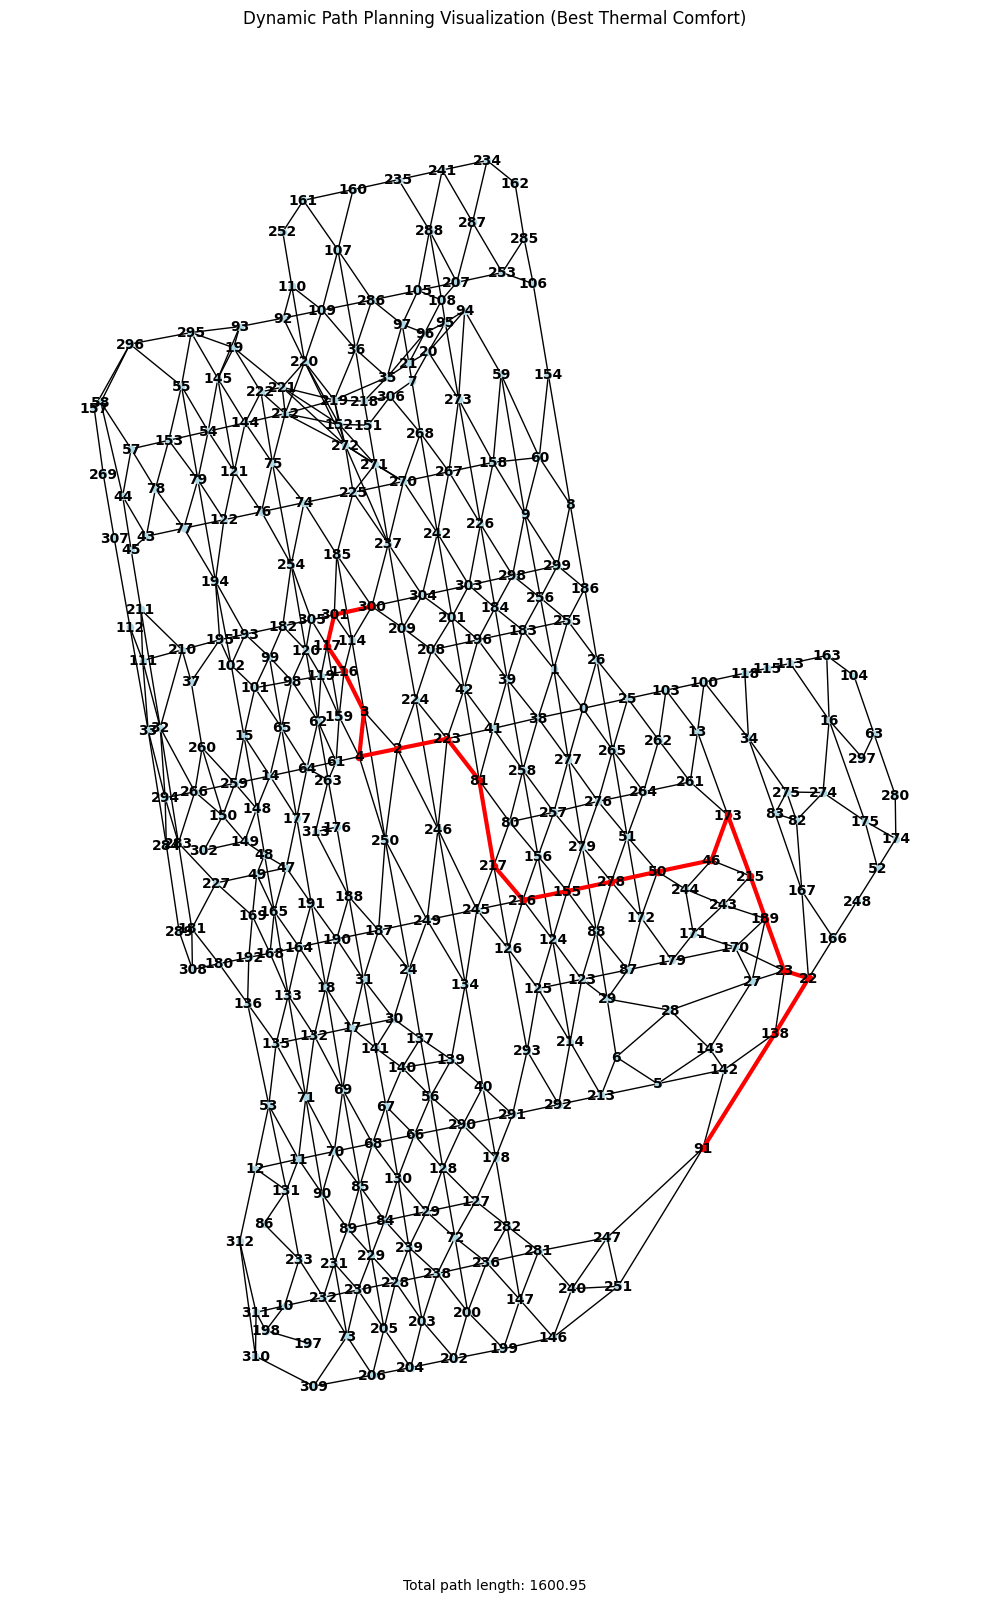

The total length of the path is 1600.95


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List

def visualize_path_and_calculate_distance(data, path: List[int], use_pos: bool = True):
    # 创建一个NetworkX图
    G = nx.Graph()

    # 添加节点和边
    num_nodes = data.x.shape[0]
    for i in range(num_nodes):
        G.add_node(i, pos=(data.x[i, 0].item(), data.x[i, 1].item()))

    edges = data.edge_index.t().tolist()
    valid_edges = [(u, v) for u, v in edges if u < num_nodes and v < num_nodes]
    G.add_edges_from(valid_edges)

    # 获取节点位置
    pos = nx.get_node_attributes(G, 'pos')
    
    plt.figure(figsize=(10, 16))
    
    # 绘制所有节点(除了路径中的节点)
    non_path_nodes = set(G.nodes()) - set(path)
    nx.draw_networkx_nodes(G, pos, nodelist=list(non_path_nodes), node_color='lightblue', node_size=20)
    
    # 绘制路径中的所有节点为红色
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='r', node_size=20)
    
    # 绘制边和标签
    nx.draw_networkx_edges(G, pos, width=1, arrows=False)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # 绘制路径边
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=3)
    
    # 计算路径总长度
    total_distance = sum(data.x[node, 2].item() for node in path[:-1])
    
    plt.title("Dynamic Path Planning Visualization (Best Thermal Comfort)")
    plt.text(0.5, -0.05, f"Total path length: {total_distance:.2f}", 
             horizontalalignment='center', 
             transform=plt.gca().transAxes)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return total_distance

# 使用示例:
total_distance = visualize_path_and_calculate_distance(data, result_path, use_pos=True)
# print(f"The total length of the path is {total_distance:.2f}")

In [ ]:
### 从路网构建图

import geopandas as gpd
import networkx as nx
import torch
from torch_geometric.data import Data
from shapely.geometry import Point, LineString

# 读取shapefile
gdf = gpd.read_file(r'D:\A_Research\A_doing_research\20240819_LLM+pathplanning\clip\clip.shp')

# 创建一个空的NetworkX图
G = nx.Graph()

# 存储节点信息
nodes = []
edge_index = []
edge_attr = []

# 遍历shapefile中的每个要素
for idx, row in gdf.iterrows():
    geom = row['geometry']
    if geom.geom_type == 'LineString':
        # 对于LineString,计算中点和长度
        mid_point = geom.interpolate(0.5, normalized=True)
        mid_point_coords = mid_point.coords[0]
        length = geom.length
        nodes.append([mid_point_coords[0], mid_point_coords[1], length])
        G.add_node(idx, pos=mid_point_coords, length=length)
    elif geom.geom_type == 'Point':
        # 对于Point,直接添加为节点,长度为0
        point_coords = geom.coords[0]
        nodes.append([point_coords[0], point_coords[1], 0])
        G.add_node(idx, pos=point_coords, length=0)

# 添加边
for idx1, row1 in gdf.iterrows():
    geom1 = row1['geometry']
    if geom1.geom_type == 'LineString':
        for idx2, row2 in gdf.iterrows():
            if idx1 < idx2:  # 避免重复检查
                geom2 = row2['geometry']
                if geom2.geom_type == 'LineString':
                    if geom1.touches(geom2):
                        G.add_edge(idx1, idx2)
                        edge_index.append([idx1, idx2])
                        edge_index.append([idx2, idx1])  # 添加反向边
                        edge_attr.append([1.0])  # 可以根据需要修改边的属性
                        edge_attr.append([1.0])  # 反向边的属性

# 转换为PyG的Data对象
x = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

print(pyg_data)

# 进行一些基本的网络分析
print(f"节点数量: {G.number_of_nodes()}")
print(f"边数量: {G.number_of_edges()}")

# 计算平均度
avg_degree = sum(dict(G.degree()).values()) / float(G.number_of_nodes())
print(f"平均度: {avg_degree:.2f}")


import torch
from pyproj import Transformer

# 创建一个从EPSG:2326到EPSG:4326的转换器
transformer = Transformer.from_crs("EPSG:2326", "EPSG:4326", always_xy=True)

def convert_coordinates(tensor):
    # 提取x和y坐标
    x, y = tensor[:, 0], tensor[:, 1]
    x_np, y_np = x.numpy(), y.numpy()
    lon, lat = transformer.transform(x_np, y_np)
    lon_tensor = torch.from_numpy(lon).float()
    lat_tensor = torch.from_numpy(lat).float()
    return torch.stack((lon_tensor, lat_tensor, tensor[:, 2]), dim=1)

pyg_data.x = convert_coordinates(pyg_data.x)
torch.save(pyg_data, 'graph_data.pt')